In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import zipfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from skimage import color, io
from scipy.misc import imresize

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.models import Model

np.random.seed(31337)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Read preds 
from six.moves import cPickle as pickle
pickle_file = 'catfish.pickle'

def unpickle(pickle_file):
    try:
        with open(pickle_file) as f:
            data=pickle.load(f)
    except Exception as e:
      print('Unable to load data from', pickle_file, ':', e)
      raise
    return data


In [3]:
# ResNet50 preds

#X_train_ResNet50=unpickle('ResNet50_train_preds.pickle')
#X_verify_ResNet50=unpickle('ResNet50_verify_preds.pickle')
#X_test_ResNet50=unpickle('ResNet50_test_preds.pickle')

# Squeeznet preds
X_train_squeezenet=np.load('squeezenet_train_preds-86528D.npy')
X_hard_squeezenet= np.load('squeezenet_hard_preds-86528D.npy')
X_test_squeezenet= np.load('squeezenet_test_preds-86528D.npy')

# labels
Y_train=np.load('catfish-Y_train.npy')
Y_hard=np.load('catfish-Y_hard.npy')
Y_train = np_utils.to_categorical(Y_train, 2)
Y_hard = np_utils.to_categorical(Y_hard, 2)

In [4]:

print(X_train_squeezenet.shape)
print(X_hard_squeezenet.shape)

print(Y_train.shape)
#print(X_hard_squeezenet)

(23814, 13, 13, 512)
(1186, 13, 13, 512)
(23814, 2)


In [6]:
# Build model_squeezenet

model = Sequential()
model.add(Convolution2D(2,1,1, input_shape=(13,13,512),border_mode='valid',activation="linear",name="conv10"))
model.add(Activation(activation='relu', name='relu_conv10'))
model.add(GlobalAveragePooling2D())
model.add(Activation(activation='softmax', name='loss'))


model.summary()


# Compile model_squeezenet
model.compile(loss='categorical_crossentropy', optimizer='adam')#, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.output_shape


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv10 (Convolution2D)           (None, 13, 13, 2)     1026        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
relu_conv10 (Activation)         (None, 13, 13, 2)     0           conv10[0][0]                     
____________________________________________________________________________________________________
globalaveragepooling2d_2 (Global (None, 2)             0           relu_conv10[0][0]                
____________________________________________________________________________________________________
loss (Activation)                (None, 2)             0           globalaveragepooling2d_2[0][0]   
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_______________________

(None, 2)

In [7]:
# Fit squeezenet the model 
history = model.fit(X_train_squeezenet, Y_train, 
                             #validation_data=(X_verify_squeezenet, Y_verify),
                             validation_split=0.33, 
                             nb_epoch=200, batch_size=10000, 
                             callbacks=[early_stop],
                             verbose=0)
# list all data in history
print(history.history.keys())

['val_categorical_crossentropy', 'loss', 'categorical_crossentropy', 'val_loss']


In [129]:
model.save_weights('catfish_transfer_learning2_keras.h5')

In [21]:
score_test = model.evaluate(X_train_squeezenet, Y_train, verbose=0)

#print("%s: %.2f%%" % (model.metrics_names, score_test*100))
print("%s: %.2f%%" % (model.metrics_names[1], score_test[1]*100))

score_valid = model.evaluate(X_hard_squeezenet, Y_hard, verbose=0)

#print("%s: %.2f%%" % (model.metrics_names, score_valid*100))
print("%s: %.2f%%" % (model.metrics_names[1], score_valid[1]*100))

#sklearn.metrics.log_loss(

categorical_crossentropy: 6.51%
categorical_crossentropy: 16.94%


In [35]:
Y_train_preds=model.predict(X_train_squeezenet)
Y_hard_preds=model.predict(X_hard_squeezenet)

In [37]:
from sklearn.metrics import log_loss

print(log_loss(Y_train, Y_train_preds))
print(log_loss(Y_hard,Y_hard_preds))

0.0650548389909
0.169380625403


In [38]:
X_hard_squeezenet_rot90=np.load('squeezenet_hard_preds-86528D-rot90.npy')
X_hard_squeezenet_rot180=np.load('squeezenet_hard_preds-86528D-rot180.npy')
X_hard_squeezenet_rot270=np.load('squeezenet_hard_preds-86528D-rot270.npy')

In [39]:
Y_hard_preds_rot90=model.predict(X_hard_squeezenet_rot90)
Y_hard_preds_rot180=model.predict(X_hard_squeezenet_rot180)
Y_hard_preds_rot270=model.predict(X_hard_squeezenet_rot270)

In [40]:
print(log_loss(Y_hard,Y_hard_preds))
print(log_loss(Y_hard,Y_hard_preds_rot90))
print(log_loss(Y_hard,Y_hard_preds_rot180))
print(log_loss(Y_hard,Y_hard_preds_rot270))

0.169380625403
0.711909774043
1.18849881703
0.664004522541


In [47]:
Y_hard_preds_total=np.add(Y_hard_preds,Y_hard_preds_rot90)
Y_hard_preds_total=Y_hard_preds+Y_hard_preds_rot90
Y_hard_preds_total/=2
print(log_loss(Y_hard,Y_hard_preds_total))

0.273967514669


loss: 6.51%


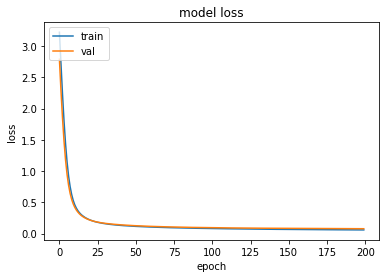

In [18]:
#print("%s: %.2f%%" % (model.metrics_names, score_test*100))
#print("%s: %.2f%%" % (model.metrics_names, score_valid*100))
print("%s: %.2f%%" % (model.metrics_names[0], score_test[0]*100))

# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
# Fit squeezenet the model 
history = model.fit(X_train_squeezenet, Y_train, 
                             #validation_data=(X_verify_squeezenet, Y_verify),
                             validation_split=0.33, 
                             nb_epoch=230, batch_size=10000, 
                             callbacks=[early_stop],initial_epoch=220,
                             verbose=0)
# list all data in history
print(history.history.keys())

['val_categorical_crossentropy', 'loss', 'categorical_crossentropy', 'val_loss']


In [58]:
score_test = model.evaluate(X_train_squeezenet, Y_train, verbose=0)

#print("%s: %.2f%%" % (model.metrics_names, score_test*100))
print("%s: %.2f%%" % (model.metrics_names[1], score_test[1]*100))

score_valid = model.evaluate(X_hard_squeezenet, Y_hard, verbose=0)

#print("%s: %.2f%%" % (model.metrics_names, score_valid*100))
print("%s: %.2f%%" % (model.metrics_names[1], score_valid[1]*100))

categorical_crossentropy: 6.76%
categorical_crossentropy: 9.89%


In [59]:
Y_test_squeezenet=model.predict(X_test_squeezenet)
#Y_test_ResNet50=model_ResNet50.predict(X_test_squeezenet)

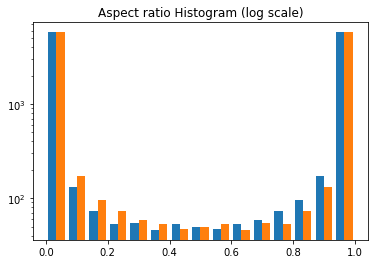

In [60]:
#plt.hist(Y_test_ResNet50, bins='auto', log=True) 
#plt.title("Aspect ratio Histogram (log scale)")
#plt.show()

plt.hist(Y_test_squeezenet, bins='auto', log=True) 
plt.title("Aspect ratio Histogram (log scale)")
plt.show()

In [61]:
# Read preds 
from six.moves import cPickle as pickle
pickle_file = 'catfish.pickle'

def unpickle(pickle_file):
    try:
        with open(pickle_file) as f:
            data=pickle.load(f)
    except Exception as e:
      print('Unable to load data from', pickle_file, ':', e)
      raise
    return data

# Read labels

save=unpickle('catfish.pickle')
train_images_sane=save['train_images_sane']
train_images=save['train_images']
insane_indices=save['insane_indices']
test_images=save['test_images']


import re
test_ids=[re.split('/|\.',i)[1] for i in test_images]

In [62]:
#Y_test_ResNet50_csv=np.column_stack((test_ids,Y_test_ResNet50))
Y_test_squeezenet_csv=np.column_stack((test_ids,Y_test_squeezenet[:,1]))


In [78]:
#np.savetxt('Y_test_ResNet50.csv',Y_test_ResNet50_csv, fmt="%s,%s", header=("id,label"),comments='')
np.savetxt('Y_test_squeezene.csv',Y_test_squeezenet_csv, fmt="%s,%s", header=("id,label"),comments='')

In [79]:
print(test_ids[1658])

11543


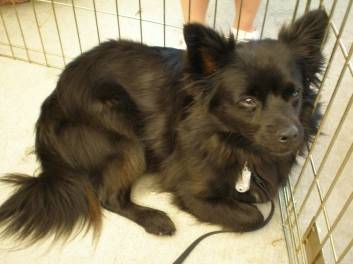

0.6297459

In [128]:
num=1698
display(Image(test_images[num]))
Y_test_squeezenet[:,1][num]

In [132]:
model.load_weights('catfish_transfer_learning_keras.h5')
Y_test_squeezenet=model.predict(X_test_squeezenet)


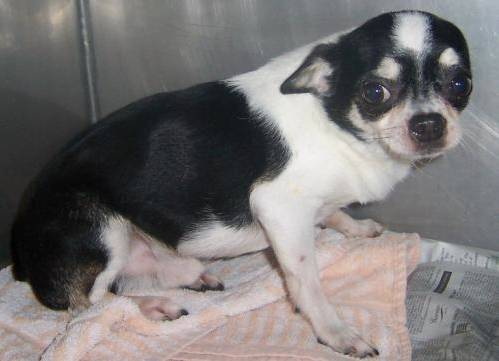

0.99339432

In [375]:
num=679
display(Image(test_images[num]))
Y_test_squeezenet[:,1][num]


In [142]:
import sys
sys.path.append("keras-squeezenet")
from keras.applications.resnet50 import preprocess_input, decode_predictions


from squeezenet import get_squeezenet
from keras.layers import Input, Dense
from keras.models import Model

squeezenet_model = get_squeezenet(1000, dim_ordering='tf')
squeezenet_model.compile(loss="categorical_crossentropy", optimizer="adam")
squeezenet_model.load_weights('keras-squeezenet/model/squeezenet_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

squeezenet_model = Model(input=squeezenet_model.inputs, output=squeezenet_model.layers[61].output)

#ueezenet_model.summary()

(164, 227, 3)
((0, 63), (0, 0), (0, 0))
(227, 227, 3)


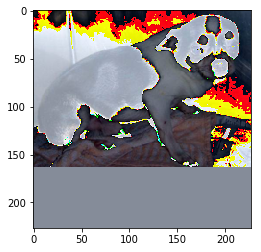

0.966403


In [377]:
IMAGE_SIZE=227
from keras.applications.resnet50 import preprocess_input,decode_predictions
from scipy import misc
im = misc.imread(test_images[num])

(w, h,_) = im.shape
if (w>h): # height is greater than width
   resizeto = (IMAGE_SIZE, int (round (IMAGE_SIZE * (float (h)  / w))));
else:
   resizeto = (int (round (IMAGE_SIZE * (float (w)  / h))), IMAGE_SIZE);

im = misc.imresize(im, resizeto ,interp='bicubic').astype(np.float32)
print(im.shape)
# padd image
paddim=np.array((IMAGE_SIZE,IMAGE_SIZE))-np.array(resizeto)
npad=((0,paddim[0]),(0,paddim[1]),(0,0))

print (npad)
im = np.pad(im,npad, mode='constant')
print(im.shape)



#img3 = cv2.copyMakeBorder(img2, 0, IMAGE_SIZE - img2.shape[0], 0, IMAGE_SIZE - img2.shape[1], cv2.BORDER_CONSTANT, 0)

#im = misc.imresize(im, (227, 227),interp='bicubic').astype(np.float32)
im = np.expand_dims(im, axis=0)
im=preprocess_input(im)

res = squeezenet_model.predict(im)
plt.imshow(im[0, :, :, ::-1]/255)
plt.show()

res = squeezenet_model.predict(im)
print(model.predict(res)[:,1][0])
dog0=model.predict(res)[:,1][0]

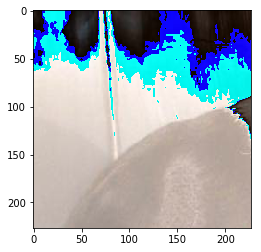

0.286572


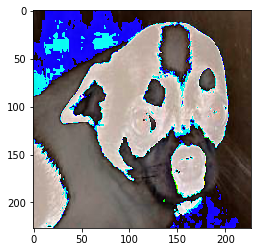

0.998548


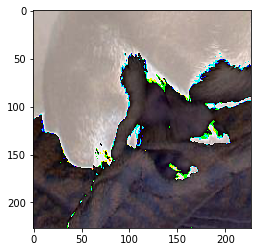

0.219205


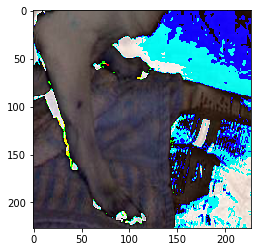

0.236853


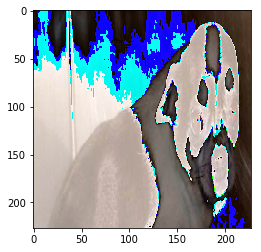

0.91706
[0.28657237, 0.99854797, 0.21920477, 0.23685309, 0.91706008]
0.531648


In [378]:
im = misc.imread(test_images[num])
(ly, lx,_) = im.shape

im=im[:ly / 2, :lx / 2,:]

im = misc.imresize(im, (227, 227),interp='bicubic').astype(np.float32)
im = np.expand_dims(im, axis=0)
im=preprocess_input(im)

res = squeezenet_model.predict(im)
plt.imshow(im[0]/255)
plt.show()

res = squeezenet_model.predict(im)
print(model.predict(res)[:,1][0])

dog=[]
dog.append(model.predict(res)[:,1][0])

im = misc.imread(test_images[num])
(ly, lx,_) = im.shape

im=im[:ly / 2, lx / 2:,:]

im = misc.imresize(im, (227, 227),interp='bicubic').astype(np.float32)
im = np.expand_dims(im, axis=0)
im=preprocess_input(im)

res = squeezenet_model.predict(im)
plt.imshow(im[0]/255)
plt.show()

res = squeezenet_model.predict(im)
print(model.predict(res)[:,1][0])
dog.append(model.predict(res)[:,1][0])

im = misc.imread(test_images[num])
(ly, lx,_) = im.shape

im=im[ly / 2:, :lx / 2,:]

im = misc.imresize(im, (227, 227),interp='bicubic').astype(np.float32)
im = np.expand_dims(im, axis=0)
im=preprocess_input(im)

res = squeezenet_model.predict(im)
plt.imshow(im[0]/255)
plt.show()

res = squeezenet_model.predict(im)
print(model.predict(res)[:,1][0])
dog.append(model.predict(res)[:,1][0])


im = misc.imread(test_images[num])
(ly, lx,_) = im.shape

im=im[ly / 2:, lx / 2:,:]

im = misc.imresize(im, (227, 227),interp='bicubic').astype(np.float32)
im = np.expand_dims(im, axis=0)
im=preprocess_input(im)

res = squeezenet_model.predict(im)
plt.imshow(im[0]/255)
plt.show()

res = squeezenet_model.predict(im)
print(model.predict(res)[:,1][0])
dog.append(model.predict(res)[:,1][0])


# left/right
im = misc.imread(test_images[num])
(ly, lx,_) = im.shape

im=im[:ly / 2, :,:]

im = misc.imresize(im, (227, 227),interp='bicubic').astype(np.float32)
im = np.expand_dims(im, axis=0)
im=preprocess_input(im)

res = squeezenet_model.predict(im)
plt.imshow(im[0]/255)
plt.show()

res = squeezenet_model.predict(im)
print(model.predict(res)[:,1][0])
dog.append(model.predict(res)[:,1][0])



print(dog)
print(np.mean(dog))

In [379]:
dog.append(dog0)
if (dog0>0.5):
    print(np.max(dog))
else:
    print(np.min(dog))

dog0

0.998548


0.96640331